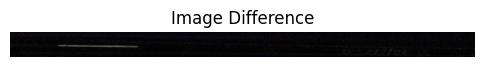

In [1]:
import numpy as np
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import os

# Define file names
base_path = 'cropped_capturing_shotts_001.jpg'
input_path = 'cropped_capturing_shotts_026.jpg'
output_path = 'image_difference_01.jpg'  # Saved so user can download

def load_or_generate(path, size=(256, 256)):
    """
    Try loading an image from `path`. If it doesn't exist,
    generate a random RGB image for demonstration purposes.
    """
    if os.path.isfile(path):
        img = Image.open(path).convert('RGB')
        return img
    # Generate a placeholder image
    rng = np.random.default_rng(seed=42 if 'base' in path else 43)
    arr = rng.integers(0, 256, size + (3,), dtype=np.uint8)
    img = Image.fromarray(arr, 'RGB')
    return img

# Load images (or create placeholders)
img1 = load_or_generate(base_path)
img2 = load_or_generate(input_path, img1.size)

# Ensure both images are the same size
if img1.size != img2.size:
    img2 = img2.resize(img1.size)

# Compute absolute difference
diff = ImageChops.difference(img1, img2)

# Save the result
diff.save(output_path)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(diff)
plt.axis('off')
plt.title('Image Difference')
plt.show()


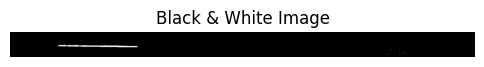

'image_bw_01.jpg'

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
img_path = 'image_difference_01.jpg'
img = Image.open(img_path).convert('RGB')

# Convert to black and white (binary) using threshold
# First convert to grayscale
gray_img = img.convert('L')

# Apply a threshold to convert to black & white
threshold = 50
bw_img = gray_img.point(lambda x: 255 if x > threshold else 0, mode='1')

# Save the black & white image
bw_path = 'image_bw_01.jpg'
bw_img.save(bw_path)

# Display the result
plt.figure(figsize=(6, 4))
plt.imshow(bw_img, cmap='gray')
plt.title("Black & White Image")
plt.axis('off')
plt.show()

bw_path


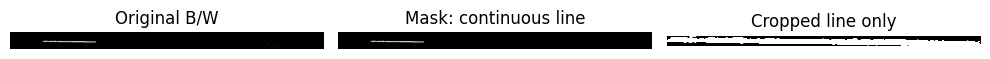

In [3]:
"""
Extract the continuous white line from a noisy black‑and‑white image.

INPUT  :  image_bw.jpg   (1‑bit black & white; white = 255, black = 0)
OUTPUT :  white_line_only.jpg   – the line cropped to its tight bounding box
          white_line_mask.jpg   – mask image showing only the line
"""

from PIL import Image
import numpy as np
from scipy import ndimage   # part of SciPy
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1. Load as binary mask  (white -> 1, black -> 0)
# ---------------------------------------------------------------------
bw = Image.open("image_bw_01.jpg").convert("1")   # 1‑bit mode
mask = np.array(bw, dtype=np.uint8)           # values are 0 or 1

# ---------------------------------------------------------------------
# 2. Label connected white regions (4‑connected neighbourhood)
# ---------------------------------------------------------------------
labels, n = ndimage.label(mask, structure=[[0,1,0],
                                           [1,1,1],
                                           [0,1,0]])
if n == 0:
    raise ValueError("No white pixels found at all.")

# ---------------------------------------------------------------------
# 3. Identify which labelled region is the LINE
#    • longest width  OR  • largest area  OR  • most pixels in same row
#    Here: choose component with the *largest bounding‑box width*
# ---------------------------------------------------------------------
best_label     = None
best_width     = -1
slices         = ndimage.find_objects(labels)   # bounding boxes for each label

for i, sl in enumerate(slices, start=1):        # labels start at 1
    if sl is None:                              # label not used
        continue
    y0, y1 = sl[0].start, sl[0].stop            # rows
    x0, x1 = sl[1].start, sl[1].stop            # columns
    width  = x1 - x0
    # Optional: demand that the component be "thin" (line‑like):
    height = y1 - y0
    if width > best_width and height <= 10:     # tweak '10' if line thicker
        best_label = i
        best_width = width

if best_label is None:
    raise ValueError("Couldn’t find a continuous line – adjust criteria.")

# ---------------------------------------------------------------------
# 4. Create a mask/image containing *only* that component
# ---------------------------------------------------------------------
line_mask = (labels == best_label).astype(np.uint8) * 255   # 255 = white
line_mask_img = Image.fromarray(line_mask, mode="L")
line_mask_img.save("white_line_mask_01.jpg")

# Bounding box for cropping
sl = slices[best_label - 1]
crop_box = (sl[1].start, sl[0].start, sl[1].stop, sl[0].stop)

# ---------------------------------------------------------------------
# 5. Crop original B/W image to just the white line region
# ---------------------------------------------------------------------
cropped_line = bw.crop(crop_box)
cropped_line.save("white_line_only_01.jpg")

# ---------------------------------------------------------------------
# 6. Quick preview (optional)
# ---------------------------------------------------------------------
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(bw, cmap="gray")
plt.title("Original B/W")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(line_mask_img, cmap="gray")
plt.title("Mask: continuous line")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cropped_line, cmap="gray")
plt.title("Cropped line only")
plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
from PIL import Image
import numpy as np

# Step 1: Load the cropped line image (from previous step)
img = Image.open("white_line_only_01.jpg").convert("1")  # 1-bit mode
arr = np.array(img)

# Step 2: Find which columns contain at least one white pixel
# In 1-bit mode: white = 1, black = 0
white_columns = np.any(arr == 1, axis=0)  # axis=0 => columns

# Step 3: Count them
num_white_columns = np.sum(white_columns)

print(f"✅ Number of columns with white pixels: {num_white_columns}")


✅ Number of columns with white pixels: 321


In [5]:
from PIL import Image
import numpy as np

# Step 1: Load the image
img = Image.open("white_line_only_01.jpg").convert("1")
arr = np.array(img)

# Step 2: Calculate the number of white-pixel columns
white_columns = np.any(arr == 1, axis=0)
num_white_columns = np.sum(white_columns)

# Step 3: Define total Celsius equivalent for the full width
# Known: 382 pixels correspond to 12 °C
reference_pixels = 382
reference_celsius = 12

# Step 4: Calculate Celsius per pixel dynamically
celsius_per_pixel = reference_celsius / reference_pixels

# Step 5: Compute actual temperature (PPT) from measured width
ppt_value = (num_white_columns * celsius_per_pixel) + 3.8

# Step 6: Output
print(f"✅ Number of columns with white pixels: {num_white_columns}")
print(f"📏 Celsius per pixel: {celsius_per_pixel:.6f} °C/pixel")
print(f"🌡️  Calculated PPT (Celsius): {ppt_value:.2f} °C")


✅ Number of columns with white pixels: 321
📏 Celsius per pixel: 0.031414 °C/pixel
🌡️  Calculated PPT (Celsius): 13.88 °C
